In [1]:
!pip install astro-datasets numpy matplotlib albumentations

     |████████████████████████████████| 9.4 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 123 kB 52.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 50.4 MB/s eta 0:00:01
     |████████████████████████████████| 12.2 MB 21.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 72.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.2 MB 53.3 MB/s eta 0:00:01
     |████████████████████████████████| 295 kB 54.5 MB/s eta 0:00:01
     |████████████████████████████████| 965 kB 54.1 MB/s eta 0:00:01
     |████████████████████████████████| 33.8 MB 30.0 MB/s eta 0:00:01
     |████████████████████████████████| 701 kB 86.4 MB/s eta 0:00:01
     |████████████████████████████████| 14.0 MB 23.1 MB/s eta 0:00:01
     |████████████████████████████████| 48.3 MB 20.6 MB/s eta 0:00:01
     |████████████████████████████████| 110 kB 58.5 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 13.6 MB/s eta 0:00:01
     |██████████████████████████

In [2]:
import numpy as np
import time, sys, os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import astro_datasets
import matplotlib.pyplot as plt
import albumentations as alb

2022-11-23 14:53:00.596280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
(cmd_train, cmd_test, cmd_val), info = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'IllustrisTNG', 'field': 'Mtot', 
                                                 'parameters': ['sigma8']})

2022-11-23 14:53:02.973820: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/IllustrisTNG_Mtot_sigma8/cmd/1.0.4.incompleteW0I72D/cmd-train.tfrecord*...…

Dataset cmd downloaded and prepared to /root/tensorflow_datasets/IllustrisTNG_Mtot_sigma8/cmd/1.0.4. Subsequent calls will reuse this data.


2022-11-23 14:57:13.269873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 14:57:13.817079: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78935 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:c4:00.0, compute capability: 8.0


In [4]:
(simba_train, simba_test, simba_val), info_simba = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'SIMBA', 'field': 'Mtot', 
                                                 'parameters': ['sigma8']})

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/SIMBA_Mtot_sigma8/cmd/1.0.4.incompleteY1EHP3/cmd-train.tfrecord*...:   0%|…

Dataset cmd downloaded and prepared to /root/tensorflow_datasets/SIMBA_Mtot_sigma8/cmd/1.0.4. Subsequent calls will reuse this data.


In [5]:
# define preprocessing, normalization and augmentation functions

def normalize(image, label):  
    image = tf.math.asinh(image)
    image = image - 26
    return image, label

def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[256, 256])
    return aug_img

def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image],\
                                Tout=tf.float32)
    return aug_img, label

def set_shapes(img, label, img_shape=(256, 256, 1)):
    img.set_shape(img_shape)
    label.set_shape(1,)
    return img, label

# Define augmentation pipeline

transforms = alb.Compose([alb.VerticalFlip(p=0.6),
                          alb.HorizontalFlip(p=0.6),
                          alb.RandomRotate90(p=0.6)])


In [6]:
btch_size = 128

In [7]:
cmd_train = cmd_train.repeat(count=3) # increase dataset size
cmd_train = cmd_train.map(process_data)
cmd_train = cmd_train.map(set_shapes)
cmd_train = cmd_train.map(normalize)
cmd_train = cmd_train.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_test = cmd_test.map(normalize)
cmd_test = cmd_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_val = cmd_val.map(normalize)
cmd_val = cmd_val.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
simba_test = simba_test.map(normalize)
simba_test = simba_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
H = 7

In [10]:
#design CNN architecture
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same', input_shape=(256, 256, 1)),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(128*H, kernel_size=4, strides=1, padding = 'valid'),  
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Flatten(),  
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64*H),
  tf.keras.layers.LeakyReLU(0.2), 
  tf.keras.layers.Dropout(0.2),  
  tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 14)      140       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 14)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 14)      1778      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 14)     56        
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256, 256, 14)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 14)      798       
                                                        

In [11]:
opt = tf.keras.optimizers.Adam(beta_1=0.5, beta_2=0.999)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)

In [12]:
#compile model, set the optimiser and the loss as defined above 
model.compile(optimizer=opt,
              loss='mae',
              metrics=['mse'])

In [13]:
epochs = 50

In [14]:
checkpoint_path = "./cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 verbose=1,
                                                 save_best_only=True)

model.fit(cmd_train, epochs=epochs, 
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True), reduce_lr, cp_callback], 
          validation_data=cmd_val)

Epoch 1/50


2022-11-23 15:01:27.351047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-11-23 15:01:29.417426: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-23 15:01:29.666809: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1c360330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-23 15:01:29.666848: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2022-11-23 15:01:29.672232: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-11-23 15:01:29.813094: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pr

317/317 [==============================] - ETA: 0s - loss: 0.3329 - mse: 0.5954
Epoch 1: val_loss improved from inf to 0.76276, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 117s 324ms/step - loss: 0.3329 - mse: 0.5954 - val_loss: 0.7628 - val_mse: 0.7356 - lr: 0.0010
Epoch 2/50
317/317 [==============================] - ETA: 0s - loss: 0.1398 - mse: 0.0752
Epoch 2: val_loss improved from 0.76276 to 0.14947, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 100s 317ms/step - loss: 0.1398 - mse: 0.0752 - val_loss: 0.1495 - val_mse: 0.0330 - lr: 0.0010
Epoch 3/50
317/317 [==============================] - ETA: 0s - loss: 0.0890 - mse: 0.0478
Epoch 3: val_loss did not improve from 0.14947
317/317 [==============================] - 95s 299ms/step - loss: 0.0890 - mse: 0.0478 - val_loss: 0.6111 - val_mse: 1.8621 - lr: 0.0010
Epoch 4/50
317/317 [==============================] - ETA: 0s - loss: 0.0679 - mse: 0.0254
Epoch 4: val_loss improved from 0.14947 to 0.12429, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 101s 320ms/step - loss: 0.0679 - mse: 0.0254 - val_loss: 0.1243 - val_mse: 0.0203 - lr: 0.0010
Epoch 5/50
317/317 [==============================] - ETA: 0s - loss: 0.0611 - mse: 0.0193
Epoch 5: val_loss improved from 0.12429 to 0.10217, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 102s 321ms/step - loss: 0.0611 - mse: 0.0193 - val_loss: 0.1022 - val_mse: 0.0206 - lr: 0.0010
Epoch 6/50
317/317 [==============================] - ETA: 0s - loss: 0.0575 - mse: 0.0145
Epoch 6: val_loss improved from 0.10217 to 0.03328, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 102s 321ms/step - loss: 0.0575 - mse: 0.0145 - val_loss: 0.0333 - val_mse: 0.0017 - lr: 0.0010
Epoch 7/50
317/317 [==============================] - ETA: 0s - loss: 0.0504 - mse: 0.0117
Epoch 7: val_loss did not improve from 0.03328
317/317 [==============================] - 95s 299ms/step - loss: 0.0504 - mse: 0.0117 - val_loss: 0.0566 - val_mse: 0.0131 - lr: 0.0010
Epoch 8/50
317/317 [==============================] - ETA: 0s - loss: 0.0477 - mse: 0.0096
Epoch 8: val_loss did not improve from 0.03328
317/317 [==============================] - 96s 302ms/step - loss: 0.0477 - mse: 0.0096 - val_loss: 0.2257 - val_mse: 0.0602 - lr: 0.0010
Epoch 9/50
317/317 [==============================] - ETA: 0s - loss: 0.0476 - mse: 0.0076
Epoch 9: val_loss did not improve from 0.03328
317/317 [==============================] - 95s 301ms/step - loss: 0.0476 - mse: 0.0076 - val_loss: 0.1344 - val_mse: 0.0205 - lr: 0.0010
Epoch 10/50
317/317 [================

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 102s 321ms/step - loss: 0.0361 - mse: 0.0050 - val_loss: 0.0278 - val_mse: 0.0019 - lr: 0.0010
Epoch 17/50
317/317 [==============================] - ETA: 0s - loss: 0.0359 - mse: 0.0044
Epoch 17: val_loss did not improve from 0.02779
317/317 [==============================] - 96s 302ms/step - loss: 0.0359 - mse: 0.0044 - val_loss: 0.6981 - val_mse: 1.5219 - lr: 0.0010
Epoch 18/50
317/317 [==============================] - ETA: 0s - loss: 0.0341 - mse: 0.0041
Epoch 18: val_loss did not improve from 0.02779
317/317 [==============================] - 96s 302ms/step - loss: 0.0341 - mse: 0.0041 - val_loss: 0.0903 - val_mse: 0.0122 - lr: 0.0010
Epoch 19/50
317/317 [==============================] - ETA: 0s - loss: 0.0336 - mse: 0.0038
Epoch 19: val_loss did not improve from 0.02779
317/317 [==============================] - 95s 300ms/step - loss: 0.0336 - mse: 0.0038 - val_loss: 0.1488 - val_mse: 0.0338 - lr: 0.0010
Epoch 20/50
317/317 [==========

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 101s 319ms/step - loss: 0.0176 - mse: 6.2138e-04 - val_loss: 0.0215 - val_mse: 0.0030 - lr: 9.0000e-05
Epoch 38/50
317/317 [==============================] - ETA: 0s - loss: 0.0176 - mse: 6.3480e-04
Epoch 38: val_loss did not improve from 0.02154
317/317 [==============================] - 95s 301ms/step - loss: 0.0176 - mse: 6.3480e-04 - val_loss: 0.0746 - val_mse: 0.0071 - lr: 9.0000e-05
Epoch 39/50
317/317 [==============================] - ETA: 0s - loss: 0.0175 - mse: 6.0728e-04
Epoch 39: val_loss did not improve from 0.02154
317/317 [==============================] - 95s 298ms/step - loss: 0.0175 - mse: 6.0728e-04 - val_loss: 0.0861 - val_mse: 0.0087 - lr: 9.0000e-05
Epoch 40/50
317/317 [==============================] - ETA: 0s - loss: 0.0173 - mse: 5.9242e-04
Epoch 40: val_loss did not improve from 0.02154
317/317 [==============================] - 94s 297ms/step - loss: 0.0173 - mse: 5.9242e-04 - val_loss: 0.0360 - val_mse: 0.0017 - lr

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 101s 318ms/step - loss: 0.0173 - mse: 5.8220e-04 - val_loss: 0.0168 - val_mse: 7.7130e-04 - lr: 9.0000e-05
Epoch 42/50
317/317 [==============================] - ETA: 0s - loss: 0.0172 - mse: 5.7255e-04
Epoch 42: val_loss did not improve from 0.01675
317/317 [==============================] - 94s 297ms/step - loss: 0.0172 - mse: 5.7255e-04 - val_loss: 0.0628 - val_mse: 0.0058 - lr: 9.0000e-05
Epoch 43/50
317/317 [==============================] - ETA: 0s - loss: 0.0171 - mse: 5.5830e-04
Epoch 43: val_loss did not improve from 0.01675
317/317 [==============================] - 96s 303ms/step - loss: 0.0171 - mse: 5.5830e-04 - val_loss: 0.0514 - val_mse: 0.0033 - lr: 9.0000e-05
Epoch 44/50
317/317 [==============================] - ETA: 0s - loss: 0.0171 - mse: 5.6433e-04
Epoch 44: val_loss did not improve from 0.01675
317/317 [==============================] - 95s 299ms/step - loss: 0.0171 - mse: 5.6433e-04 - val_loss: 0.0412 - val_mse: 0.0032 

In [15]:
best_model = tf.keras.models.load_model(checkpoint_path)

In [16]:
best_model.evaluate(cmd_test)

6/6 [==============================] - 1s 31ms/step - loss: 0.0169 - mse: 9.1294e-04


[0.016895459964871407, 0.0009129395475611091]

In [17]:
best_model.evaluate(simba_test)

6/6 [==============================] - 0s 29ms/step - loss: 0.0283 - mse: 0.0020


[0.028278492391109467, 0.0019903697539120913]

In [18]:
yhat_cmd = best_model.predict(cmd_test)

6/6 [==============================] - 1s 27ms/step


In [19]:
yhat_simba = best_model.predict(simba_test)

6/6 [==============================] - 0s 24ms/step


In [20]:
lbl_cmd = np.concatenate([y for x, y in cmd_test], axis=0)

In [21]:
lbl_simba = np.concatenate([y for x, y in simba_test], axis=0)

In [22]:
yhat_cmd.shape

(750, 1)

In [23]:
lbl_cmd.shape

(750, 1)

In [24]:
np.mean(np.abs((lbl_cmd - yhat_cmd) / lbl_cmd))

0.022326365

In [25]:
np.mean(np.abs((lbl_simba - yhat_simba) / lbl_simba))

0.036309015

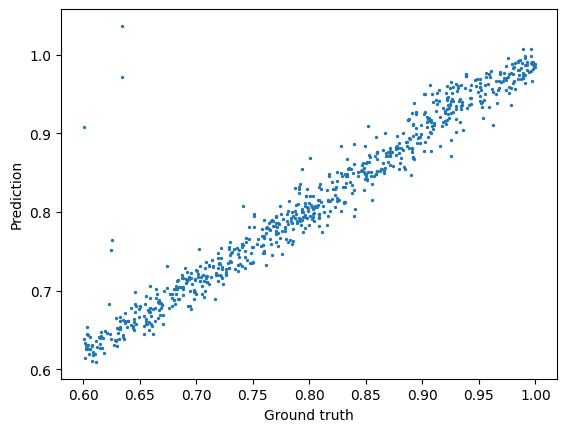

In [26]:
plt.scatter(lbl_cmd, yhat_cmd, s=2)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

plt.show()